In [1]:
!pip3 install git+https://github.com/zalandoresearch/flair

  Cloning https://github.com/zalandoresearch/flair to /tmp/pip-req-build-m25ialjt
  Running command git clone -q https://github.com/zalandoresearch/flair /tmp/pip-req-build-m25ialjt
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 143kB 6.8MB/s eta 0:00:01


  Created wheel for flair: filename=flair-0.4.2-cp36-none-any.whl size=102754 sha256=d6474b207d26704633e38ec18b2df7c4ca42504f9cc5d4b22f9e23da0312c3b3
  Stored in directory: /tmp/pip-ephem-wheel-cache-8_3dc2wt/wheels/8e/47/da/f22675cf094ae69648b301413ef8639296775f876b38a5507f
Successfully built flair
  Created wheel for segtok: filename=segtok-1.5.7-cp36-none-any.whl size=23257 sha256=a3cb5c0065e59be731183efa9f0aa449a786d61479c6cfeb5951adb5395a0a75
  Stored in directory: /tmp/.cache/pip/wheels/15/ee/a8/6112173f1386d33eebedb3f73429cfa41a4c3084556bcee254
  Created wheel for sqlitedict: filename=sqlitedict-1.6.0-cp36-none-any.whl size=14689 sha256=72fdda6576d90b320e4aa0b469609727cf6076c8d0d35616bffcec9316fc1239
  Stored in directory: /tmp/.cache/pip/wheels/bd/57/d3/907c3ee02d35e66f674ad0106e61f06eeeb98f6ee66a6cc3fe
Successfully built segtok sqlitedict
You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
import os
import numpy as np
import pandas as pd

%matplotlib inline

import torch
torch.cuda.is_available()

True

> ## Create a Corpus

### 1) Load from simple CSV file

In [ ]:
from flair.datasets import CSVClassificationCorpus

Great development..

### 2) FastText Format

In [3]:
from flair.data import Corpus
from flair.datasets import ClassificationCorpus

In [4]:
FILE_PATH = "../input/bbc-text.csv"
DATASET_FOLDER_PATH = "splitted_data"
# DATASET_FOLDER_PATH = os.path.join("splitted_data", FILE_PATH.split(".")[0].split("/")[1])

column_name = {
    "text": "text",
    "label": "category"
}

# file format
__label__<label_1> <text>
__label__<label_1> __label__<label_2> <text>

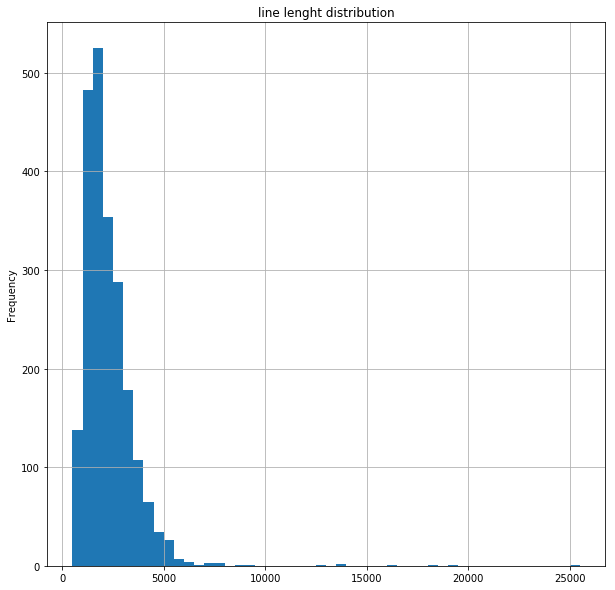

In [5]:
data_df = pd.read_csv(FILE_PATH).sample(frac=1)
data_df[column_name["label"]] = '__label__' + data_df[column_name["label"]].astype(str)

# number of chars
data_df[column_name["text"]].str.len().plot(kind="hist", title="line lenght distribution", grid=True, figsize=(10,10), bins=50);

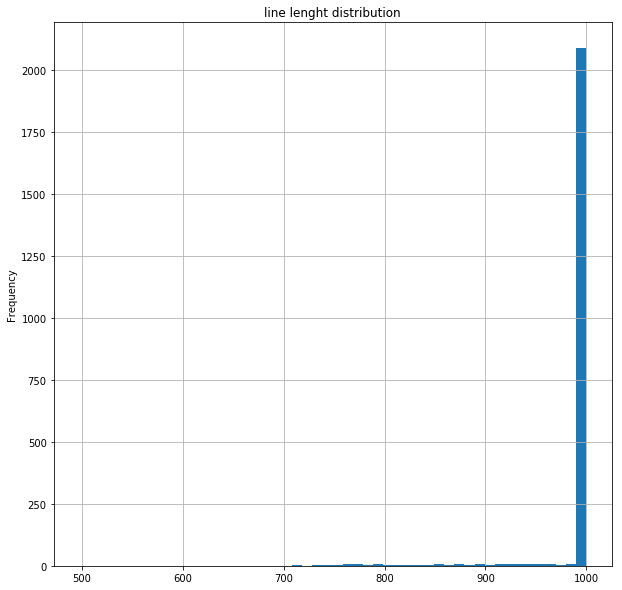

In [6]:
import re
from string import digits, punctuation

def clear_text(text, is_all_lower=True):
    punct = re.sub(r'[\.,!?&\-]', '', punctuation)
    punctuation_table = str.maketrans({key: "#" for key in punct})
    for char in ["\"", "\'"]:
        del punctuation_table[ord(char)]
    
    review_cleaned = text.apply(lambda x: re.sub(r'[^\x00-\x7F]', ' ', x))
    review_cleaned = review_cleaned.apply(lambda x: re.sub(r'[0-9]', '9', x))
    review_cleaned = review_cleaned.apply(lambda x: x.translate(punctuation_table))
    review_cleaned = review_cleaned.apply(lambda x: re.sub(r' +', ' ', x))
    review_cleaned = review_cleaned.apply(lambda x: re.sub(r' (?=[\.,!?&\-])','', x))
    
    if is_all_lower:
        review_cleaned = review_cleaned.str.lower()
        
    return review_cleaned

data_df[column_name["text"]] = clear_text(data_df["text"])
data_df[column_name["text"]] = data_df[column_name["text"]].apply(lambda x: x[:1000])

# number of chars
data_df[column_name["text"]].str.len().plot(kind="hist", title="line lenght distribution", grid=True, figsize=(10,10), bins=50);

In [7]:
if not os.path.exists(DATASET_FOLDER_PATH):
    os.makedirs(DATASET_FOLDER_PATH)
data_df.iloc[0: int(len(data_df)*0.8)].to_csv(os.path.join(DATASET_FOLDER_PATH, 'train.csv'), sep='\t', index = False, header = False)
data_df.iloc[int(len(data_df)*0.8): int(len(data_df)*0.9)].to_csv(os.path.join(DATASET_FOLDER_PATH, 'dev.csv'), sep='\t', index = False, header = False)
data_df.iloc[int(len(data_df)*0.9): ].to_csv(os.path.join(DATASET_FOLDER_PATH, 'test.csv'), sep='\t', index = False, header = False);

In [8]:
corpus = ClassificationCorpus(DATASET_FOLDER_PATH)

2019-08-11 17:36:08,963 Reading data from splitted_data
2019-08-11 17:36:08,967 Train: splitted_data/train.csv
2019-08-11 17:36:08,971 Dev: splitted_data/dev.csv
2019-08-11 17:36:08,972 Test: splitted_data/test.csv


Each line in a corpus is converted to a Sentence object annotated with the labels.

## Check distribution

In [9]:
train_df = pd.read_csv(os.path.join(DATASET_FOLDER_PATH, "train.csv"), names=["label", "text"], delimiter="\t")
train_df.label.value_counts()

__label__business         415
__label__sport            414
__label__politics         329
__label__tech             313
__label__entertainment    309
Name: label, dtype: int64

In [10]:
val_df = pd.read_csv(os.path.join(DATASET_FOLDER_PATH, "dev.csv"), names=["label", "text"], delimiter="\t")
val_df.label.value_counts()

__label__politics         48
__label__business         48
__label__sport            46
__label__tech             44
__label__entertainment    36
Name: label, dtype: int64

In [12]:
test_df = pd.read_csv(os.path.join(DATASET_FOLDER_PATH, "test.csv"), names=["label", "text"], delimiter="\t")
test_df.label.value_counts()

__label__sport            51
__label__business         47
__label__tech             44
__label__entertainment    41
__label__politics         40
Name: label, dtype: int64

## Training a Model

## OpenAI GPT-2

In [17]:
from flair.embeddings import OpenAIGPT2Embeddings, FlairEmbeddings, DocumentRNNEmbeddings
from flair.models import TextClassifier
from flair.trainers import ModelTrainer
from flair.training_utils import EvaluationMetric
# from flair.visual.training_curves import Plotter

ImportError: Cannot load backend 'TkAgg' which requires the 'tk' interactive framework, as 'headless' is currently running

In [14]:
MODEL_FOLDER_PATH = "model/OPENAIGPT2"
if not os.path.exists(MODEL_FOLDER_PATH):
    os.makedirs(MODEL_FOLDER_PATH)

In [15]:
params_train = {
    "flair_emb_forward": 'news-forward-fast',
    "flair_emb_backward": 'news-backward-fast',
    "hidden_size": 256,
    "reproject_words_dimension": 128,
    "max_epoch": 20,
    "evaluation_metric": EvaluationMetric.MICRO_ACCURACY
}

word_embeddings = [OpenAIGPT2Embeddings(), FlairEmbeddings(params_train["flair_emb_forward"]),
                   FlairEmbeddings(params_train["flair_emb_backward"])]

document_embeddings = DocumentRNNEmbeddings(word_embeddings, hidden_size=params_train["hidden_size"],
                                            reproject_words=True, reproject_words_dimension=params_train["reproject_words_dimension"])

classifier = TextClassifier(document_embeddings, label_dictionary=corpus.make_label_dictionary(), multi_label=False)

trainer = ModelTrainer(classifier, corpus)

100%|██████████| 1520013706/1520013706 [00:48<00:00, 31224924.46B/s]


2019-08-11 17:37:37,429 https://s3.eu-central-1.amazonaws.com/alan-nlp/resources/embeddings/lm-news-english-forward-1024-v0.2rc.pt not found in cache, downloading to /tmp/tmp5b_cwqbz


100%|██████████| 19689779/19689779 [00:00<00:00, 41272009.13B/s]

2019-08-11 17:37:38,072 copying /tmp/tmp5b_cwqbz to cache at /tmp/.flair/embeddings/lm-news-english-forward-1024-v0.2rc.pt


2019-08-11 17:37:38,105 removing temp file /tmp/tmp5b_cwqbz
2019-08-11 17:37:38,263 https://s3.eu-central-1.amazonaws.com/alan-nlp/resources/embeddings/lm-news-english-backward-1024-v0.2rc.pt not found in cache, downloading to /tmp/tmp8hymdgh7


100%|██████████| 19689779/19689779 [00:00<00:00, 39424017.25B/s]

2019-08-11 17:37:38,931 copying /tmp/tmp8hymdgh7 to cache at /tmp/.flair/embeddings/lm-news-english-backward-1024-v0.2rc.pt


2019-08-11 17:37:38,963 removing temp file /tmp/tmp8hymdgh7
2019-08-11 17:37:39,038 Computing label dictionary. Progress:


100%|██████████| 1780/1780 [00:10<00:00, 167.91it/s]

2019-08-11 17:37:50,071 [b'entertainment', b'politics', b'sport', b'business', b'tech']


In [16]:
learning_rate_tsv = trainer.find_learning_rate(MODEL_FOLDER_PATH, 'learning_rate.tsv')

plotter = Plotter()
plotter.plot_learning_rate(learning_rate_tsv)

2019-08-11 17:41:04,483 ----------------------------------------------------------------------------------------------------
2019-08-11 17:41:04,485 learning rate finder finished - plot model/OPENAIGPT2/learning_rate.tsv
2019-08-11 17:41:04,487 ----------------------------------------------------------------------------------------------------


NameError: name 'Plotter' is not defined

In [18]:
trainer.train(MODEL_FOLDER_PATH, max_epochs=params_train["max_epoch"])#, evaluation_metric=params_train["evaluation_metric"])

2019-08-11 17:47:51,768 ----------------------------------------------------------------------------------------------------
2019-08-11 17:47:51,772 Model: "TextClassifier(
  (document_embeddings): DocumentRNNEmbeddings(
    (embeddings): StackedEmbeddings(
      (list_embedding_0): OpenAIGPT2Embeddings(
        (model): GPT2Model(
          (wte): Embedding(50257, 1024)
          (wpe): Embedding(1024, 1024)
          (drop): Dropout(p=0.1)
          (h): ModuleList(
            (0): Block(
              (ln_1): BertLayerNorm()
              (attn): Attention(
                (c_attn): Conv1D()
                (c_proj): Conv1D()
                (attn_dropout): Dropout(p=0.1)
                (resid_dropout): Dropout(p=0.1)
              )
              (ln_2): BertLayerNorm()
              (mlp): MLP(
                (c_fc): Conv1D()
                (c_proj): Conv1D()
                (dropout): Dropout(p=0.1)
              )
            )
            (1): Block(
              (ln_1): B

2019-08-11 17:47:51,774 ----------------------------------------------------------------------------------------------------
2019-08-11 17:47:51,775 Corpus: "Corpus: 1780 train + 222 dev + 223 test sentences"
2019-08-11 17:47:51,776 ----------------------------------------------------------------------------------------------------
2019-08-11 17:47:51,777 Parameters:
2019-08-11 17:47:51,778  - learning_rate: "0.1"
2019-08-11 17:47:51,779  - mini_batch_size: "32"
2019-08-11 17:47:51,780  - patience: "3"
2019-08-11 17:47:51,780  - anneal_factor: "0.5"
2019-08-11 17:47:51,781  - max_epochs: "20"
2019-08-11 17:47:51,782  - shuffle: "True"
2019-08-11 17:47:51,783  - train_with_dev: "False"
2019-08-11 17:47:51,784 ----------------------------------------------------------------------------------------------------
2019-08-11 17:47:51,785 Model training base path: "model/OPENAIGPT2"
2019-08-11 17:47:51,786 ----------------------------------------------------------------------------------------

2019-08-11 18:07:26,743 epoch 5 - iter 35/56 - loss 2.42470578 throughput (samples/sec): 8.33
2019-08-11 18:07:46,461 epoch 5 - iter 40/56 - loss 2.39305915 throughput (samples/sec): 8.37
2019-08-11 18:08:05,937 epoch 5 - iter 45/56 - loss 2.39141402 throughput (samples/sec): 8.66
2019-08-11 18:08:25,034 epoch 5 - iter 50/56 - loss 2.38986279 throughput (samples/sec): 8.64
2019-08-11 18:08:42,845 epoch 5 - iter 55/56 - loss 2.40284807 throughput (samples/sec): 9.24
2019-08-11 18:08:43,350 ----------------------------------------------------------------------------------------------------
2019-08-11 18:08:43,351 EPOCH 5 done: loss 2.4028 - lr 0.1000
2019-08-11 18:09:11,404 DEV : loss 2.041531801223755 - score 0.2162
2019-08-11 18:09:13,408 BAD EPOCHS (no improvement): 3
2019-08-11 18:09:16,031 ----------------------------------------------------------------------------------------------------
2019-08-11 18:09:25,228 epoch 6 - iter 0/56 - loss 2.17345452 throughput (samples/sec): 41.07
2

2019-08-11 18:29:22,743 epoch 10 - iter 55/56 - loss 1.84739753 throughput (samples/sec): 9.83
2019-08-11 18:29:23,239 ----------------------------------------------------------------------------------------------------
2019-08-11 18:29:23,241 EPOCH 10 done: loss 1.8474 - lr 0.0500
2019-08-11 18:29:51,453 DEV : loss 1.7432754039764404 - score 0.2072
Epoch     9: reducing learning rate of group 0 to 2.5000e-02.
2019-08-11 18:29:53,576 BAD EPOCHS (no improvement): 4
2019-08-11 18:29:53,577 ----------------------------------------------------------------------------------------------------
2019-08-11 18:29:59,070 epoch 11 - iter 0/56 - loss 1.83586848 throughput (samples/sec): 36.12
2019-08-11 18:30:17,894 epoch 11 - iter 5/56 - loss 1.73408967 throughput (samples/sec): 8.79
2019-08-11 18:30:36,951 epoch 11 - iter 10/56 - loss 1.69875210 throughput (samples/sec): 8.76
2019-08-11 18:30:56,145 epoch 11 - iter 15/56 - loss 1.71058492 throughput (samples/sec): 8.60
2019-08-11 18:31:15,654 epo

2019-08-11 18:49:59,170 EPOCH 15 done: loss 1.6554 - lr 0.0125
2019-08-11 18:50:27,476 DEV : loss 1.6633492708206177 - score 0.2072
2019-08-11 18:50:29,617 BAD EPOCHS (no improvement): 1
2019-08-11 18:50:29,619 ----------------------------------------------------------------------------------------------------
2019-08-11 18:50:35,445 epoch 16 - iter 0/56 - loss 1.73412824 throughput (samples/sec): 33.27
2019-08-11 18:50:54,073 epoch 16 - iter 5/56 - loss 1.64891519 throughput (samples/sec): 8.85
2019-08-11 18:51:13,368 epoch 16 - iter 10/56 - loss 1.66555891 throughput (samples/sec): 8.64
2019-08-11 18:51:33,194 epoch 16 - iter 15/56 - loss 1.66543571 throughput (samples/sec): 8.40
2019-08-11 18:51:52,258 epoch 16 - iter 20/56 - loss 1.66376075 throughput (samples/sec): 8.57
2019-08-11 18:52:10,794 epoch 16 - iter 25/56 - loss 1.65871082 throughput (samples/sec): 8.88
2019-08-11 18:52:29,985 epoch 16 - iter 30/56 - loss 1.65574518 throughput (samples/sec): 8.71
2019-08-11 18:52:48,974 

2019-08-11 19:11:14,976 Testing using best model ...
2019-08-11 19:11:14,982 loading file model/OPENAIGPT2/best-model.pt
2019-08-11 19:11:41,432 0.2108	0.2108	0.2108
2019-08-11 19:11:41,433 
MICRO_AVG: acc 0.1178 - f1-score 0.2108
MACRO_AVG: acc 0.0422 - f1-score 0.06964000000000001
business   tp: 47 - fp: 176 - fn: 0 - tn: 0 - precision: 0.2108 - recall: 1.0000 - accuracy: 0.2108 - f1-score: 0.3482
entertainment tp: 0 - fp: 0 - fn: 41 - tn: 182 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
politics   tp: 0 - fp: 0 - fn: 40 - tn: 183 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
sport      tp: 0 - fp: 0 - fn: 51 - tn: 172 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
tech       tp: 0 - fp: 0 - fn: 44 - tn: 179 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-08-11 19:11:41,435 ----------------------------------------------------------------------------------------------

{'test_score': 0.2108,
 'dev_score_history': [0.2072,
  0.2162,
  0.1622,
  0.2027,
  0.2162,
  0.2072,
  0.2162,
  0.2072,
  0.2072,
  0.2072,
  0.2162,
  0.2162,
  0.1982,
  0.2162,
  0.2072,
  0.2162,
  0.2072,
  0.2162,
  0.2072,
  0.2072],
 'train_loss_history': [2.5277326745646342,
  2.447187283209392,
  2.599363299352782,
  2.5135857484170367,
  2.4028480734143938,
  2.293679403407233,
  1.8981805784361703,
  1.867765641638211,
  1.8559127364839827,
  1.8473975317818778,
  1.708465344139508,
  1.691422089934349,
  1.6866269537380763,
  1.6974598999534334,
  1.655424369232995,
  1.6472091057470866,
  1.6466106687273299,
  1.6468752260719026,
  1.6245791954653603,
  1.6190963749374663],
 'dev_loss_history': [tensor(1.9103, device='cuda:0'),
  tensor(2.5066, device='cuda:0'),
  tensor(2.1446, device='cuda:0'),
  tensor(2.3179, device='cuda:0'),
  tensor(2.0415, device='cuda:0'),
  tensor(2.5453, device='cuda:0'),
  tensor(1.9457, device='cuda:0'),
  tensor(1.8335, device='cuda:0'),

## Plot training curves

In [ ]:
from flair.visual.training_curves import Plotter

plotter = Plotter()
plotter.plot_training_curves(os.path.join(MODEL_FOLDER_PATH, 'loss.tsv'))
plotter.plot_weights(os.path.join(MODEL_FOLDER_PATH, 'weights.txt'))